MAE (Mean Absolute Error): 24.88 cycles
RMSE (Root Mean Squared Error): 34.27 cycles


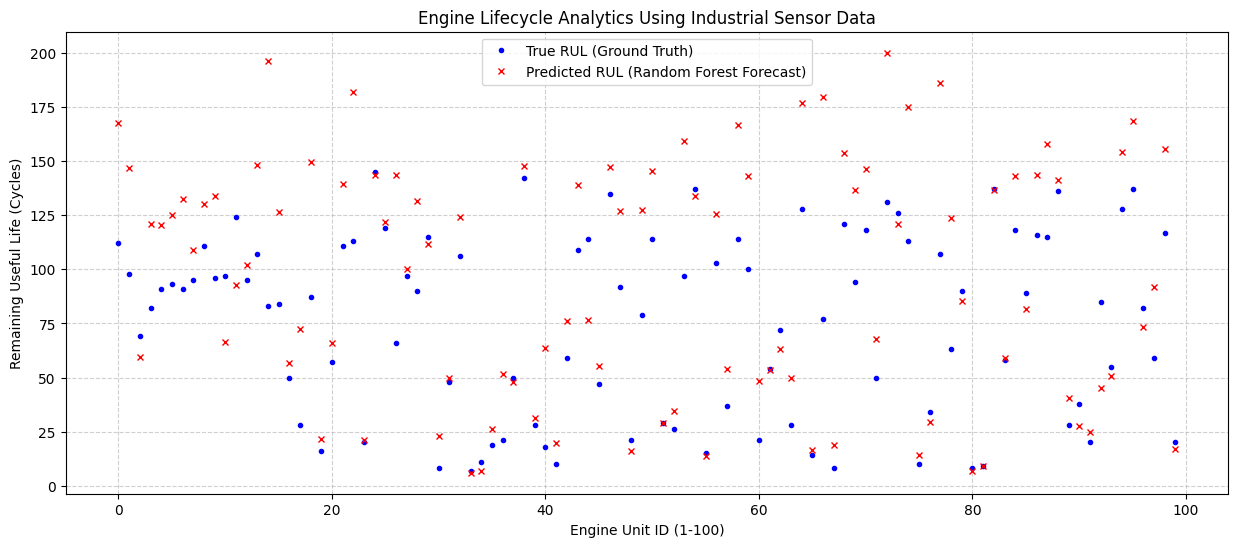

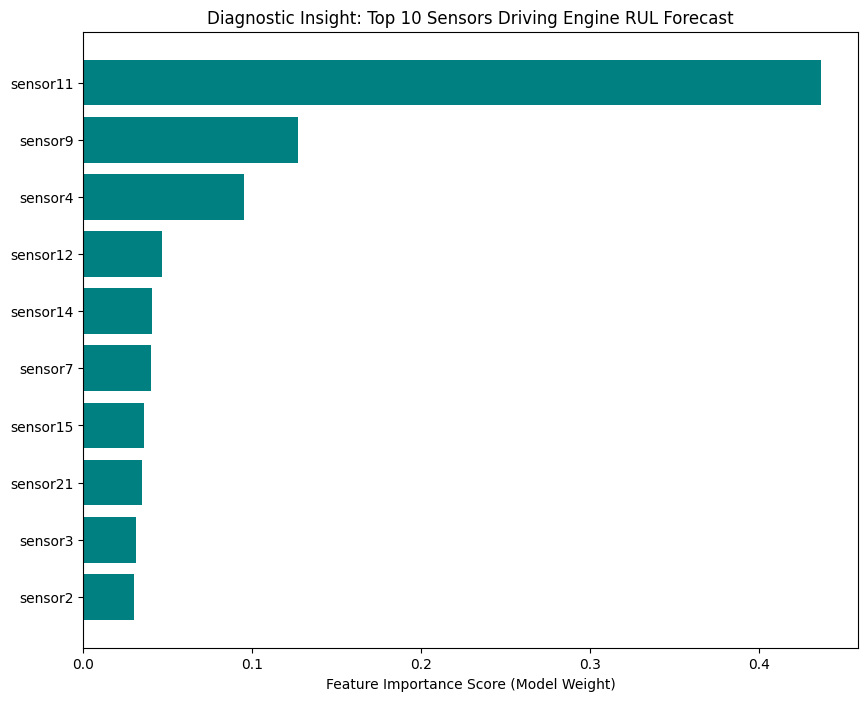

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# --- 1. Load and Prepare Training Data ---
train = pd.read_csv('./CMAPSSData/train_FD001.txt', sep=" ", header=None).iloc[:, :26]
train.columns = ['engine', 'cycle', 'setting1','setting2', 'setting3'] + [f'sensor{i}' for i in range (1,22)]

# Drop constant value columns based on variability
train = train.loc[:, train.nunique() > 1].copy()

# RUL Calculation: RUL = Max cycle - current cycle
train['RUL'] = train.groupby('engine')['cycle'].transform('max') - train['cycle']

# Define the final feature columns (sensors only)
feature_col = [col for col in train.columns if col.startswith("sensor")]
x_train = train[feature_col]
y_train = train['RUL']

# Scale the training features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)


# --- 2. Load and Prepare Test Data ---
test = pd.read_csv('./CMAPSSData/test_FD001.txt',sep=" ", header=None).iloc[:, :26]
test.columns = ['engine', 'cycle', 'setting1','setting2', 'setting3'] + [f'sensor{i}' for i in range (1,22)]

# Load true RUL values for evaluation
y_test = pd.read_csv('./CMAPSSData/RUL_FD001.txt', header=None).iloc[:, 0]


# --- 3. Prepare Test Data for Prediction ---
# Get the LAST cycle of each engine (the prediction point)
x_test_last = test.groupby('engine').last().reset_index()

# Select ONLY the features the model was trained on
x_test_features = x_test_last[feature_col]

# Scale the test features using the fitted training scaler
x_test_scaled = scaler.transform(x_test_features)


# --- 4. Model Training, Prediction, and Evaluation ---

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train_scaled, y_train)

y_pred = model.predict(x_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE (Mean Absolute Error): {mae:.2f} cycles")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f} cycles")

# --- 5. Visualization: Predictive Insight (RUL Accuracy) ---

plt.figure(figsize=(15, 6))
plt.plot(y_test, label='True RUL (Ground Truth)', color='blue', marker='o', linestyle='', markersize=3)
plt.plot(y_pred, label='Predicted RUL (Random Forest Forecast)', color='red', marker='x', linestyle='', markersize=5)
plt.title('Engine Lifecycle Analytics Using Industrial Sensor Data')
plt.xlabel('Engine Unit ID (1-100)')
plt.ylabel('Remaining Useful Life (Cycles)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- 6. Visualization: Diagnostic Insight (Feature Importance) ---

importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_col,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10], color='teal')
plt.xlabel('Feature Importance Score (Model Weight)')
plt.title('Diagnostic Insight: Top 10 Sensors Driving Engine RUL Forecast')
plt.gca().invert_yaxis()
plt.show()